<a href="https://colab.research.google.com/github/kumar-abhishek/imbalanced-machine-learning-book/blob/ch8-drw/chapter-8/Deferred_reweighting_DRW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2
from torch.utils.data.sampler import  SubsetRandomSampler

In [2]:
use_cuda = torch.cuda.is_available()

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if use_cuda else "cpu")

100%|██████████| 9912422/9912422 [00:00<00:00, 113123799.38it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 84473984.54it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24053433.81it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16227026.21it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Distribution of classes in Imbalanced dataset:
Counter({0: 5923, 1: 3596, 2: 2156, 3: 1292, 4: 774, 5: 464, 6: 278, 7: 166, 8: 100, 9: 60})


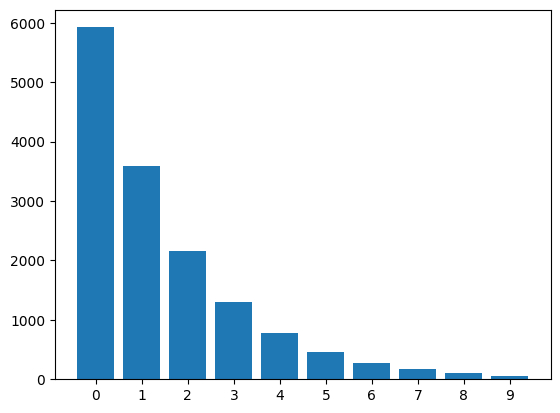

In [3]:
def get_img_num_per_cls(data, num_classes=10, imb_type='exp', imb_factor=0.01):
    img_max = len(data) / num_classes
    img_num_per_cls = []
    if imb_type == 'exp':
        for cls_idx in range(num_classes):
            num = img_max * (imb_factor**(cls_idx / (num_classes - 1.0)))
            img_num_per_cls.append(int(num))
    return img_num_per_cls

def gen_imbalanced_data(targets, img_num_per_cls):
    targets_np = np.array(targets, dtype=np.int64)
    classes = np.unique(targets_np)
    num_per_cls_dict = dict()
    idx_to_remove = []
    for the_class, the_img_num in zip(classes, img_num_per_cls):
        num_per_cls_dict[the_class] = the_img_num
        idx = np.where(targets_np == the_class)[0]
        np.random.shuffle(idx)
        selec_idx = idx[:the_img_num]
        idx_to_remove.extend(list(np.setdiff1d(idx, selec_idx)))
    return idx_to_remove

# load data
test_seq = [
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(10, shear=10)] + test_seq)

trainset = torchvision.datasets.MNIST('.', train=True, download=True, transform=train_transform)
img_num_per_cls = get_img_num_per_cls(trainset)
idx_to_remove = gen_imbalanced_data(trainset.targets, img_num_per_cls)

# print('idx_to_remove: ', idx_to_remove)
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data,
                                            idx_to_remove, axis=0)
print('Distribution of classes in Imbalanced dataset:')
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

#Preparing for validaion test
indices = list(range(len(imbalanced_train_dataset)))
np.random.seed(seed)
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(imbalanced_train_dataset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
imbalanced_train_loader = torch.utils.data.DataLoader(imbalanced_train_dataset, sampler=train_sample, batch_size=64)
val_loader = torch.utils.data.DataLoader(imbalanced_train_dataset, sampler=valid_sample, batch_size=64)

In [4]:
# # import argparse
# import random
# import copy
# import torch
# import torchvision
# import numpy as np
# import pandas as pd
# import sklearn.metrics as sm
# import torch.nn.functional as F

# use_cuda = torch.cuda.is_available()

# torch.manual_seed(42)
# random.seed(0)

# device = torch.device("cuda" if use_cuda else "cpu")
# kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# # load data
# test_seq = [
#    torchvision.transforms.ToTensor(),
#    torchvision.transforms.Normalize((0.1307,), (0.3081,))
# ]
# test_transform = torchvision.transforms.Compose(test_seq)
# train_transform = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(10, shear=10)] + test_seq)
# train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=train_transform)

# train_subset, val_subset = torch.utils.data.random_split(
#         train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(1))

# train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.', train=False, transform=test_transform),
    batch_size=1000, shuffle=True)

In [5]:
# # create imbalanced data
# torch.manual_seed(42)
num_classes = 10


# # create imbalanced data
classe_labels = range(num_classes)
# sample_probs = torch.rand(num_classes)

# idx_to_del = [i for i, label in enumerate(train_subset.dataset.train_labels)
#               if random.random() > sample_probs[label]]

# imbalanced_train_dataset = copy.deepcopy(train_dataset)
# imbalanced_train_dataset.targets = np.delete(train_subset.dataset.targets, idx_to_del, axis=0)
# imbalanced_train_dataset.data = np.delete(train_subset.dataset.data, idx_to_del, axis=0)
# imbalanced_train_loader = torch.utils.data.DataLoader(
#     imbalanced_train_dataset, batch_size=64, shuffle=True, **kwargs)

Original dataset: 14809 training samples & 10000 testing samples

Imbalanced dataset: 14809 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


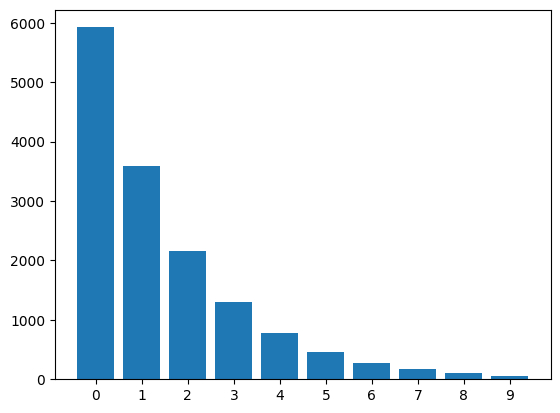

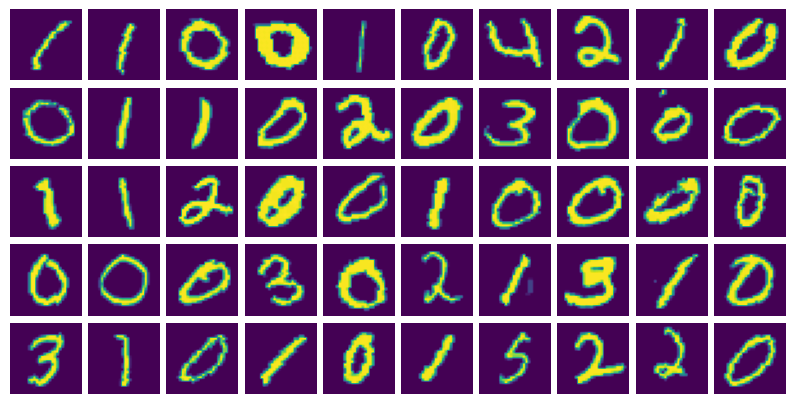

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_mnist(arr, nrow=5, ncol=10, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)

    f, a = plt.subplots(nrow, ncol, figsize=figsize)

    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')

    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()

def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'

    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()
    print('annot: ', annot)
    return annot

print('Original dataset: %d training samples & %d testing samples\n' % (
    len(imbalanced_train_loader.dataset), len(test_loader.dataset)))

print('Imbalanced dataset: %d training samples & %d testing samples\n' % (
    len(imbalanced_train_loader.dataset), len(test_loader.dataset)))

print('Distribution of classes in imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

for data, _ in imbalanced_train_loader:
    show_mnist(data)
    break

In [53]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

@torch.no_grad()
def val_loss(x, y, model, weight=None):
    prediction = model(x)
    val_loss = F.nll_loss(prediction, y, weight)
    return val_loss.item()

def process(train_loader, test_loader, weight=None, model=None):
    if model is None:
      model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    # train & test process
    def train(train_loader):
      model.train()
      train_epoch_losses = []
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = F.nll_loss(output, target, weight)
          loss.backward()
          optimizer.step()
          train_epoch_losses.append(loss)
      return train_epoch_losses


    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx


    train_losses, val_losses, test_accs, confusion_mtxes = [], [], [], []
    for epoch in range(1, 30 + 1):
        train_epoch_losses = train(train_loader)
        train_epoch_losses = torch.tensor(train_epoch_losses ).to('cpu')
        train_epoch_loss = train_epoch_losses.mean()

        for _, batch in enumerate(iter(val_loader)):
          x, y = batch
          x, y = x.to(device), y.to(device)
          validation_loss = torch.tensor(val_loss(x, y, model)).to('cpu')

        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        train_losses.append(train_epoch_loss)
        val_losses.append(validation_loss)

        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs))

    confusion_mtx = vis(test_accs, confusion_mtxes, classe_labels)
    print('confusion_mtx', confusion_mtx)
    return model, train_losses, val_losses, test_accs[np.argmax(test_accs)], confusion_mtx

Best test acc = 21.38%
Best test acc = 33.85%
Best test acc = 41.04%
Best test acc = 46.48%
Best test acc = 48.64%
Best test acc = 50.27%
Best test acc = 52.61%
Best test acc = 58.21%
Best test acc = 61.87%
Best test acc = 61.96%
Best test acc = 65.92%
Best test acc = 66.78%
Best test acc = 67.16%
Best test acc = 69.56%
Best test acc = 69.56%
Best test acc = 69.56%
Best test acc = 71.39%
Best test acc = 71.39%
Best test acc = 71.39%
Best test acc = 71.86%
Best test acc = 72.41%
Best test acc = 72.41%
Best test acc = 73.04%
Best test acc = 73.17%
Best test acc = 73.57%
Best test acc = 73.57%
Best test acc = 73.57%
Best test acc = 73.57%
Best test acc = 73.57%
Best test acc = 74.09%


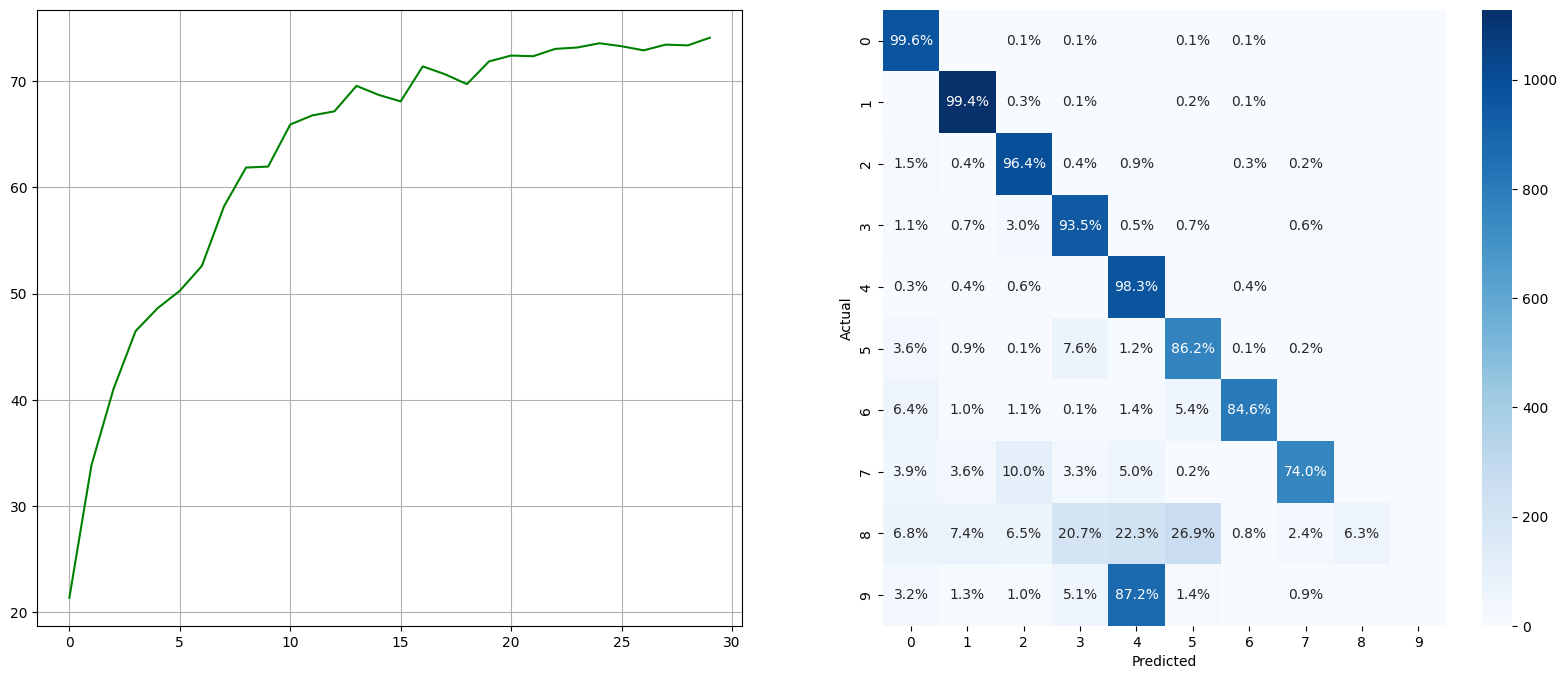

annot:  [['99.6%' '' '0.1%' '0.1%' '' '0.1%' '0.1%' '' '' '']
 ['' '99.4%' '0.3%' '0.1%' '' '0.2%' '0.1%' '' '' '']
 ['1.5%' '0.4%' '96.4%' '0.4%' '0.9%' '' '0.3%' '0.2%' '' '']
 ['1.1%' '0.7%' '3.0%' '93.5%' '0.5%' '0.7%' '' '0.6%' '' '']
 ['0.3%' '0.4%' '0.6%' '' '98.3%' '' '0.4%' '' '' '']
 ['3.6%' '0.9%' '0.1%' '7.6%' '1.2%' '86.2%' '0.1%' '0.2%' '' '']
 ['6.4%' '1.0%' '1.1%' '0.1%' '1.4%' '5.4%' '84.6%' '' '' '']
 ['3.9%' '3.6%' '10.0%' '3.3%' '5.0%' '0.2%' '' '74.0%' '' '']
 ['6.8%' '7.4%' '6.5%' '20.7%' '22.3%' '26.9%' '0.8%' '2.4%' '6.3%' '']
 ['3.2%' '1.3%' '1.0%' '5.1%' '87.2%' '1.4%' '' '0.9%' '' '']]
confusion_mtx [['99.6%' '' '0.1%' '0.1%' '' '0.1%' '0.1%' '' '' '']
 ['' '99.4%' '0.3%' '0.1%' '' '0.2%' '0.1%' '' '' '']
 ['1.5%' '0.4%' '96.4%' '0.4%' '0.9%' '' '0.3%' '0.2%' '' '']
 ['1.1%' '0.7%' '3.0%' '93.5%' '0.5%' '0.7%' '' '0.6%' '' '']
 ['0.3%' '0.4%' '0.6%' '' '98.3%' '' '0.4%' '' '' '']
 ['3.6%' '0.9%' '0.1%' '7.6%' '1.2%' '86.2%' '0.1%' '0.2%' '' '']
 ['6.4%' '1.0%

In [54]:
model, train_losses, val_losses, test_acc_crossentropy, confusion_mtx_crossentropy = process(imbalanced_train_loader, test_loader)

In [55]:
# test_acc_crossentropy
confusion_mtx_crossentropy

array([['99.6%', '', '0.1%', '0.1%', '', '0.1%', '0.1%', '', '', ''],
       ['', '99.4%', '0.3%', '0.1%', '', '0.2%', '0.1%', '', '', ''],
       ['1.5%', '0.4%', '96.4%', '0.4%', '0.9%', '', '0.3%', '0.2%', '',
        ''],
       ['1.1%', '0.7%', '3.0%', '93.5%', '0.5%', '0.7%', '', '0.6%', '',
        ''],
       ['0.3%', '0.4%', '0.6%', '', '98.3%', '', '0.4%', '', '', ''],
       ['3.6%', '0.9%', '0.1%', '7.6%', '1.2%', '86.2%', '0.1%', '0.2%',
        '', ''],
       ['6.4%', '1.0%', '1.1%', '0.1%', '1.4%', '5.4%', '84.6%', '', '',
        ''],
       ['3.9%', '3.6%', '10.0%', '3.3%', '5.0%', '0.2%', '', '74.0%', '',
        ''],
       ['6.8%', '7.4%', '6.5%', '20.7%', '22.3%', '26.9%', '0.8%',
        '2.4%', '6.3%', ''],
       ['3.2%', '1.3%', '1.0%', '5.1%', '87.2%', '1.4%', '', '0.9%', '',
        '']], dtype='<U21')

In [56]:
train_losses

[tensor(1.7558),
 tensor(1.1072),
 tensor(0.8819),
 tensor(0.7621),
 tensor(0.6496),
 tensor(0.5652),
 tensor(0.5304),
 tensor(0.4809),
 tensor(0.4654),
 tensor(0.4319),
 tensor(0.4114),
 tensor(0.3944),
 tensor(0.3777),
 tensor(0.3672),
 tensor(0.3555),
 tensor(0.3190),
 tensor(0.3178),
 tensor(0.3467),
 tensor(0.3071),
 tensor(0.2942),
 tensor(0.2873),
 tensor(0.2925),
 tensor(0.2773),
 tensor(0.2748),
 tensor(0.2763),
 tensor(0.2700),
 tensor(0.2508),
 tensor(0.2700),
 tensor(0.2551),
 tensor(0.2496)]

In [57]:
len(val_losses)

30

In [60]:
epochs = np.arange(30)+1
epochs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

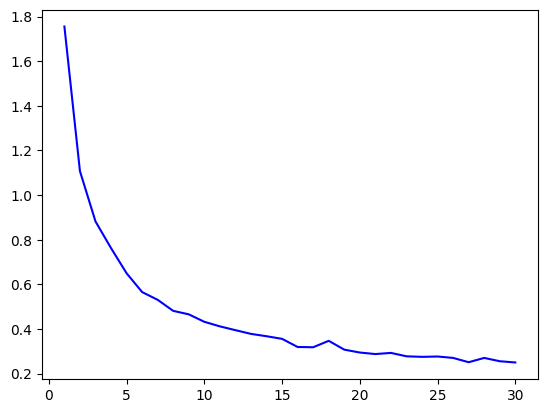

In [61]:
plt.plot(epochs, train_losses, 'b', label='Training loss')


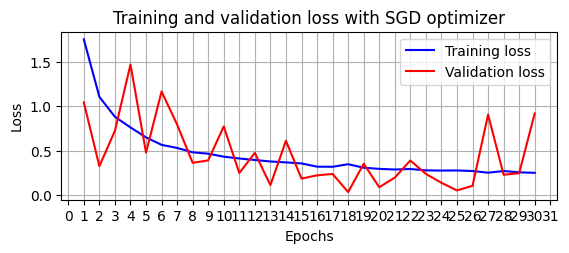

In [64]:
epochs = np.arange(30)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

In [65]:
# use the class_weights obtained using sklearn's compute_class_weight function
from sklearn.utils import class_weight
y = imbalanced_train_loader.dataset.targets
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y),y=y.numpy())
class_weights

array([ 0.25002533,  0.41181869,  0.68687384,  1.14620743,  1.91330749,
        3.19159483,  5.32697842,  8.92108434, 14.809     , 24.68166667])

Best test acc = 22.29%
Best test acc = 40.48%
Best test acc = 43.86%
Best test acc = 48.19%
Best test acc = 49.84%
Best test acc = 56.92%
Best test acc = 56.92%
Best test acc = 59.61%
Best test acc = 63.66%
Best test acc = 65.10%
Best test acc = 66.26%
Best test acc = 67.79%
Best test acc = 67.79%
Best test acc = 67.79%
Best test acc = 67.79%
Best test acc = 70.13%
Best test acc = 70.13%
Best test acc = 71.02%
Best test acc = 71.02%
Best test acc = 71.02%
Best test acc = 71.60%
Best test acc = 71.68%
Best test acc = 71.68%
Best test acc = 71.81%
Best test acc = 72.88%
Best test acc = 73.23%
Best test acc = 73.23%
Best test acc = 73.56%
Best test acc = 73.56%
Best test acc = 74.58%


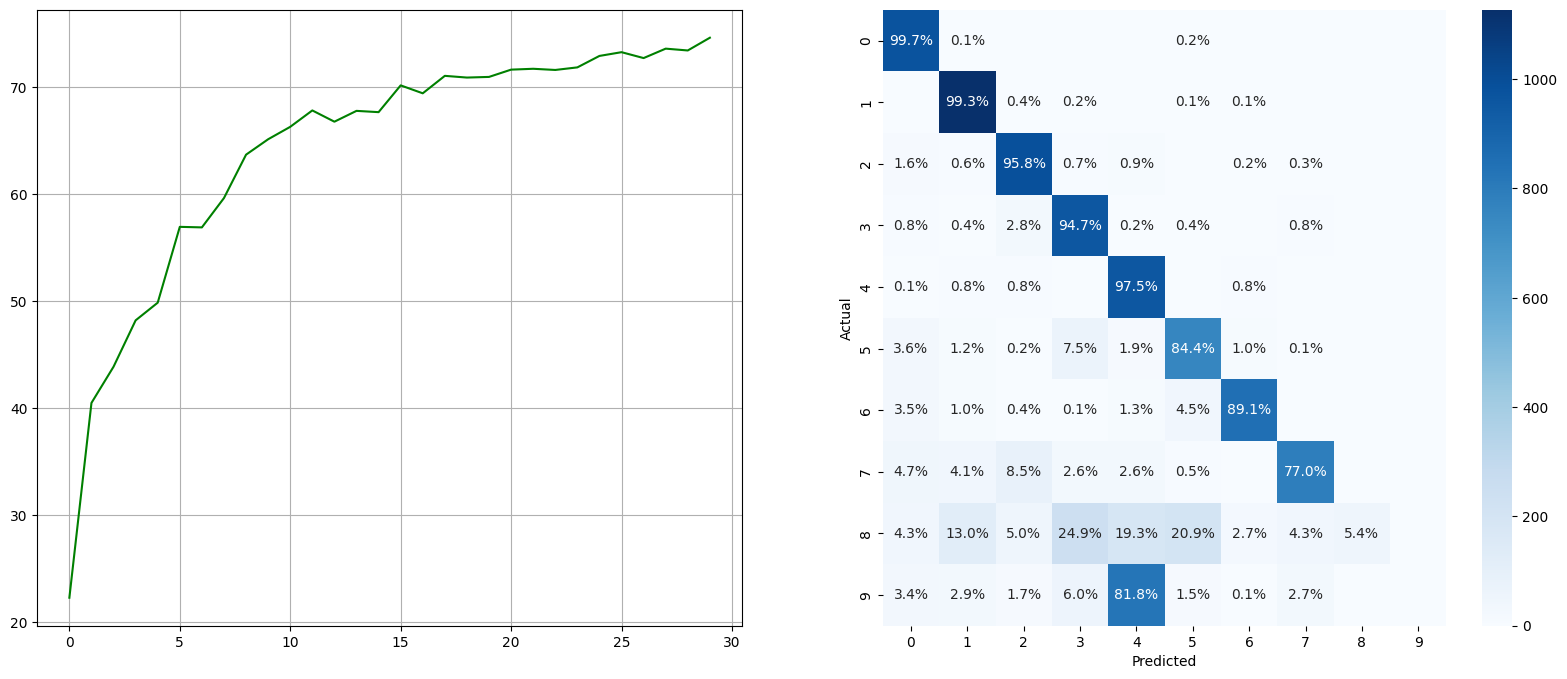

annot:  [['99.7%' '0.1%' '' '' '' '0.2%' '' '' '' '']
 ['' '99.3%' '0.4%' '0.2%' '' '0.1%' '0.1%' '' '' '']
 ['1.6%' '0.6%' '95.8%' '0.7%' '0.9%' '' '0.2%' '0.3%' '' '']
 ['0.8%' '0.4%' '2.8%' '94.7%' '0.2%' '0.4%' '' '0.8%' '' '']
 ['0.1%' '0.8%' '0.8%' '' '97.5%' '' '0.8%' '' '' '']
 ['3.6%' '1.2%' '0.2%' '7.5%' '1.9%' '84.4%' '1.0%' '0.1%' '' '']
 ['3.5%' '1.0%' '0.4%' '0.1%' '1.3%' '4.5%' '89.1%' '' '' '']
 ['4.7%' '4.1%' '8.5%' '2.6%' '2.6%' '0.5%' '' '77.0%' '' '']
 ['4.3%' '13.0%' '5.0%' '24.9%' '19.3%' '20.9%' '2.7%' '4.3%' '5.4%' '']
 ['3.4%' '2.9%' '1.7%' '6.0%' '81.8%' '1.5%' '0.1%' '2.7%' '' '']]
confusion_mtx [['99.7%' '0.1%' '' '' '' '0.2%' '' '' '' '']
 ['' '99.3%' '0.4%' '0.2%' '' '0.1%' '0.1%' '' '' '']
 ['1.6%' '0.6%' '95.8%' '0.7%' '0.9%' '' '0.2%' '0.3%' '' '']
 ['0.8%' '0.4%' '2.8%' '94.7%' '0.2%' '0.4%' '' '0.8%' '' '']
 ['0.1%' '0.8%' '0.8%' '' '97.5%' '' '0.8%' '' '' '']
 ['3.6%' '1.2%' '0.2%' '7.5%' '1.9%' '84.4%' '1.0%' '0.1%' '' '']
 ['3.5%' '1.0%' '0.4%' '0.

In [66]:
model, train_losses_first_pass, val_losses_first_pass, _, _ = process(imbalanced_train_loader, test_loader)

Best test acc = 79.54%
Best test acc = 80.78%
Best test acc = 83.58%
Best test acc = 83.58%
Best test acc = 83.58%
Best test acc = 85.72%
Best test acc = 85.72%
Best test acc = 85.72%
Best test acc = 89.23%
Best test acc = 89.23%
Best test acc = 89.23%
Best test acc = 89.23%
Best test acc = 89.23%
Best test acc = 89.23%
Best test acc = 89.23%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%
Best test acc = 92.06%


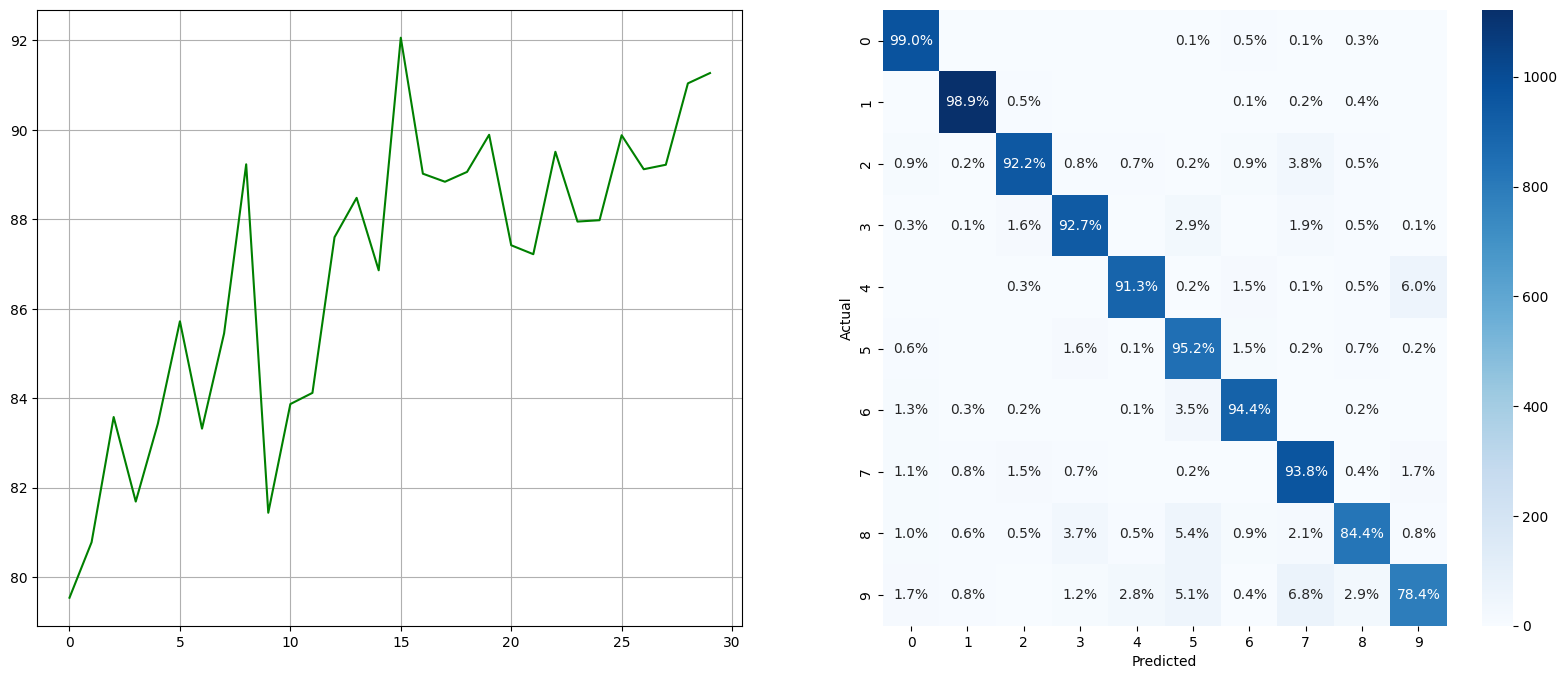

annot:  [['99.0%' '' '' '' '' '0.1%' '0.5%' '0.1%' '0.3%' '']
 ['' '98.9%' '0.5%' '' '' '' '0.1%' '0.2%' '0.4%' '']
 ['0.9%' '0.2%' '92.2%' '0.8%' '0.7%' '0.2%' '0.9%' '3.8%' '0.5%' '']
 ['0.3%' '0.1%' '1.6%' '92.7%' '' '2.9%' '' '1.9%' '0.5%' '0.1%']
 ['' '' '0.3%' '' '91.3%' '0.2%' '1.5%' '0.1%' '0.5%' '6.0%']
 ['0.6%' '' '' '1.6%' '0.1%' '95.2%' '1.5%' '0.2%' '0.7%' '0.2%']
 ['1.3%' '0.3%' '0.2%' '' '0.1%' '3.5%' '94.4%' '' '0.2%' '']
 ['1.1%' '0.8%' '1.5%' '0.7%' '' '0.2%' '' '93.8%' '0.4%' '1.7%']
 ['1.0%' '0.6%' '0.5%' '3.7%' '0.5%' '5.4%' '0.9%' '2.1%' '84.4%' '0.8%']
 ['1.7%' '0.8%' '' '1.2%' '2.8%' '5.1%' '0.4%' '6.8%' '2.9%' '78.4%']]
confusion_mtx [['99.0%' '' '' '' '' '0.1%' '0.5%' '0.1%' '0.3%' '']
 ['' '98.9%' '0.5%' '' '' '' '0.1%' '0.2%' '0.4%' '']
 ['0.9%' '0.2%' '92.2%' '0.8%' '0.7%' '0.2%' '0.9%' '3.8%' '0.5%' '']
 ['0.3%' '0.1%' '1.6%' '92.7%' '' '2.9%' '' '1.9%' '0.5%' '0.1%']
 ['' '' '0.3%' '' '91.3%' '0.2%' '1.5%' '0.1%' '0.5%' '6.0%']
 ['0.6%' '' '' '1.6%' '0.1%

In [67]:
model, train_losses_second_pass, val_losses_second_pass, test_acc_drw, confusion_mtx_drw = process(imbalanced_train_loader, test_loader,
                                                                                                   weight=torch.from_numpy(class_weights).cuda(0).float(),
                                                                                                   model=model)

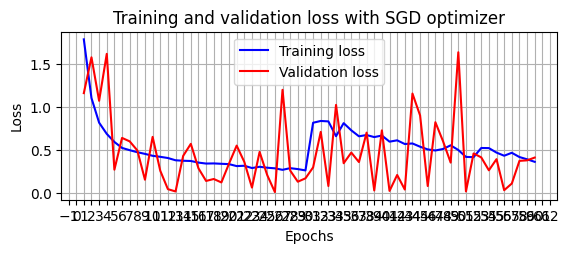

In [72]:
epochs = np.arange(60)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses_first_pass+train_losses_second_pass, 'b', label='Training loss')
plt.plot(epochs, val_losses_first_pass+val_losses_second_pass, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

As we can see, although for some classes the accuracy dropped, the accuracy actually improved for the most imbalanced classes of 9,6 and 2(in order).

After applying 2 phase training of deferred-reweighting technique, we see the accuracies of most imbalanced classes change as follows when compared to just reweighting:
* class 9: from 93.6% to 96.0%
* class 6: from 98.1% to 98.7%



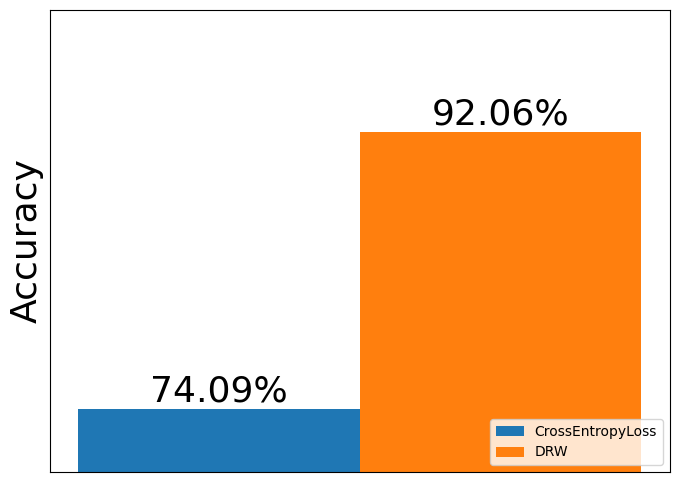

In [73]:
fig= plt.subplots(figsize=(8, 6))
# plt.rcParams['font.size'] = 16

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]

p1 = plt.bar(br1, np.array(test_acc_crossentropy).astype(float), width = 0.1, label ='CrossEntropyLoss')
p2 = plt.bar(br2, np.array(test_acc_drw).astype(float), width = 0.1, label ='DRW')

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=26)
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=26)

plt.ylim(70, 100)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.legend(loc='lower right')
plt.ylabel('Accuracy', fontsize=26)
plt.show()

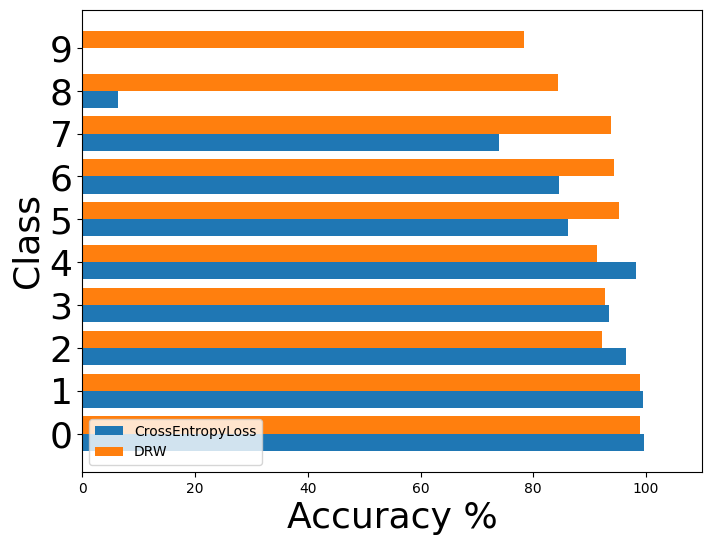

In [79]:
fig, ax = plt.subplots(figsize=(8, 6))

br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]
class_percentages_crossentropy = [confusion_mtx_crossentropy[i][i][:-1] for i in range(10)]
class_percentages_crossentropy = [0 if i=='' else i for i in class_percentages_crossentropy]
class_percentages_drw = [confusion_mtx_drw[i][i][:-1] for i in range(10)]

p1 = plt.barh(br1, np.array(class_percentages_crossentropy).astype(float), height=0.4, label='CrossEntropyLoss')
p2 = plt.barh(br2, np.array(class_percentages_drw).astype(float), height=0.4, label='DRW')

plt.yticks([r + 0.2 for r in range(10)],
           ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], fontsize=26)
plt.xlim(0, 110)
plt.legend(loc='lower left')
plt.ylabel('Class', fontsize=26)
plt.xlabel('Accuracy %', fontsize=26)
plt.show()